In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
rgblist = sns.color_palette('tab10')

Inputs:

In [2]:
k = 10                     # Number of arms
n = 1000                   # Number of rounds

The cell below defines the environment.

In [3]:
class Stochastic_mab():
    def __init__(self, k, seed=10):
        self.k = k
        np.random.seed(seed)
        self.means = np.random.uniform(0,1,k)
        self.max_r = max(self.means)
    
    def plot_means(self):
        """This function helps visualization of quality of the experts"""
        ticks = []
        for i in range(1,self.k+1):
            ticks.append('Expert-'+str(i))
        
        plt.scatter(range(1,self.k+1), self.means, marker='_')
        plt.axhline(max(self.means), linestyle = '--', color=rgblist[3], alpha=0.4)
        plt.xticks(range(1,self.k+1), ticks, rotation=90)
        plt.xlim(0,self.k+1)
        plt.ylim(0,1)
    
    def get_reward(self, arm):
        """This function returns reward by each expert in each round"""
        return np.greater(self.means[arm], np.random.uniform()).astype(np.int32)

In [4]:
seed = 10
env = Stochastic_mab(k,seed)

Plot the reward mean of each arm.

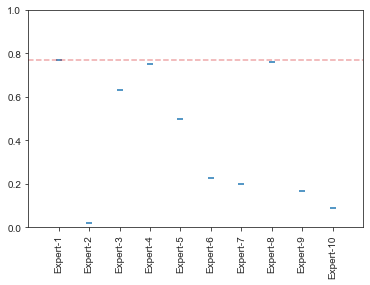

In [5]:
env.plot_means()

In [6]:
gap = env.max_r-env.means
gap = gap[np.nonzero(gap)]
print("Minimum gap",np.round(np.min(gap),3))

Minimum gap 0.011


In [7]:
def ucb(k, n, delta):
    # Initialize arrays and variables to store data
    cumul_reg = []
    sum_r = 0
    
    # Initialize reward estimate
    rewards = np.zeros(k)
    counts = np.zeros(k)
    
    for t in range(n):
        
        if t < k:
            # Choose an arm
            a_t = int(t%k)
        else:
            # Choose the arm that maximizes ucb
            a_t = np.argmax(np.divide(rewards, np.maximum(counts,np.ones(k))) + np.sqrt(2*np.log(1/delta)/np.maximum(counts,np.ones(k))))
        
        # get the reward
        r = env.get_reward(a_t)
        ar = env.means[a_t]
        
        # update reward and count
        rewards[a_t] += r
        counts[a_t] += 1
        
        # save cumulative regret till now
        sum_r += ar
        cumul_reg.append(env.max_r*(t+1) - sum_r)
        
    return cumul_reg

Test plot

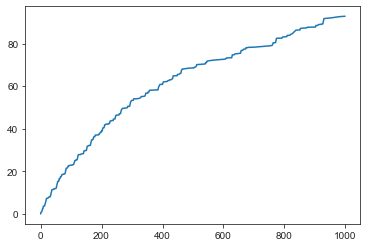

In [8]:
reg = ucb(k,n,1/n)
plt.plot(reg)

Plot cumulative regrets for `KL-UCB` algorithm averaged over 100 runs.

In [9]:
def ucb_avg(k, n, runs):
    plots = np.zeros((runs,n))
    for run in range(runs):
        plots[run] = ucb(k,n,1/n)
    avg_plot = np.mean(plots, axis=0)
    std_plot = np.std(plots, axis=0)
    plt.plot(np.arange(1,n+1), avg_plot)
    plt.fill_between(np.arange(1,n+1), avg_plot-std_plot, avg_plot+std_plot, alpha=0.2)
    plt.xlim(0, n)
    plt.ylim(0)
    plt.xlabel('Time steps')
    plt.ylabel('Average regret')
    plt.title('Cumulative regret plot')
    plt.show()
    return

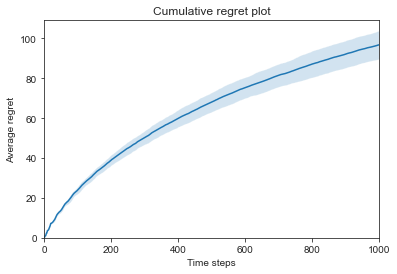

In [10]:
runs = 100
ucb_avg(k, n, runs)

Write a function for `Thompson sampling` algorithm that returns cumulative regret in an array. Plot cumulative regret for a single run.

In [11]:
def thompson_sampling(k, n):
    # Initialize arrays and variables to store data
    cumul_reg = []
    sum_r = 0
    
    # Initialize reward estimate
    success = np.zeros(k)
    failure = np.zeros(k)
    
    for t in range(n):
        # Choose the 
        theta = []
        for i in range(k):
            theta.append(np.random.beta(success[i]+1, failure[i]+1))
        a_t = np.argmax(theta)
        
        # get the reward
        r = env.get_reward(a_t)
        ar = env.means[a_t]
        
        # update reward and count
        success[a_t] += r
        failure[a_t] += (1-r)
        
        # save cumulative regret till now
        sum_r += r
        cumul_reg.append(env.max_r*(t+1) - sum_r)
    
    return cumul_reg

Test plot

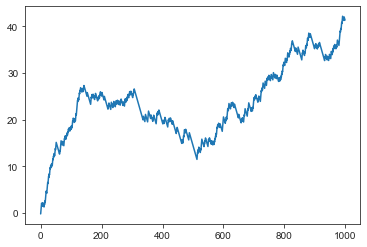

In [12]:
reg = thompson_sampling(k,n)
plt.plot(reg)

Plot cumulative regrets for `Thompson Sampling` algorithm averaged over 100 runs.

In [13]:
def ts_avg(k, n, runs):
    plots = np.zeros((runs,n))
    for run in range(runs):
        plots[run] = thompson_sampling(k,n)
    avg_plot = np.mean(plots, axis=0)
    std_plot = np.std(plots, axis=0)
    plt.plot(np.arange(1,n+1), avg_plot)
    plt.fill_between(np.arange(1,n+1), avg_plot-std_plot, avg_plot+std_plot, alpha=0.2)
    plt.xlim(0, n)
    plt.ylim(0)
    plt.xlabel('Time steps')
    plt.ylabel('Average regret')
    plt.title('Cumulative regret plot')
    plt.show()
    return

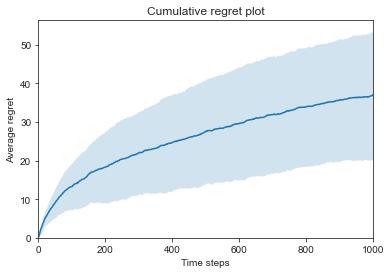

In [14]:
runs = 100
ts_avg(k, n, runs)

Write a function for gradient-based MAB algorithm that returns cumulative regret in an array. Plot cumulative regret for a single run.

In [48]:
def grad_mab(k, n, alpha):
    # Initialize arrays and variables to store data
    cumul_reg = []
    sum_r = 0
    
    # Initialize reward estimate
    rewards = np.zeros(k)
    counts = np.zeros(k)
    theta = np.zeros(k)
    
    for t in range(n):
        
        pi = np.exp(alpha*theta)
        pi = pi/sum(pi)
        
        a_t = np.random.choice(np.arange(k), p=pi)
        
        # get the reward
        r = env.get_reward(a_t)
        ar = env.means[a_t]
        
        Delta = np.zeros((k,k))
        
        A = np.repeat(np.expand_dims(pi,0),k,axis=0).T
        A = np.eye(k) - A
        for i in range(k):
            Delta[:,i] = pi[i]*A[:,i]
        
        theta = theta + np.matmul(Delta, np.divide(rewards, np.maximum(counts,np.ones(k))))
        
        # update reward and count
        rewards[a_t] += r
        counts[a_t] += 1
        
        # save cumulative regret till now
        sum_r += ar
        cumul_reg.append(env.max_r*(t+1) - sum_r)
    
    return cumul_reg

In [49]:
alpha = 1

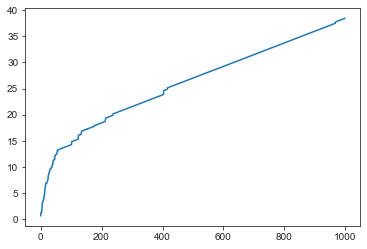

In [50]:
reg = grad_mab(k,1000,alpha)
plt.plot(reg)

In [51]:
def gm_avg(k, n, runs):
    plots = np.zeros((runs,n))
    for run in range(runs):
        plots[run] = grad_mab(k,n,alpha)
    avg_plot = np.mean(plots, axis=0)
    std_plot = np.std(plots, axis=0)
    plt.plot(np.arange(1,n+1), avg_plot)
    plt.fill_between(np.arange(1,n+1), avg_plot-std_plot, avg_plot+std_plot, alpha=0.2)
    plt.xlim(0, n)
    plt.ylim(0)
    plt.xlabel('Time steps')
    plt.ylabel('Average regret')
    plt.title('Cumulative regret plot')
    plt.show()
    return

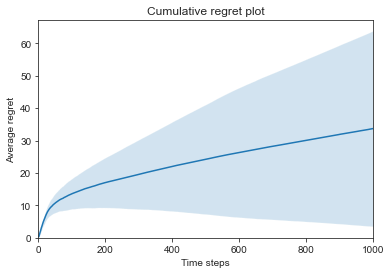

In [52]:
runs = 100
gm_avg(k, n, runs)